<a href="https://colab.research.google.com/github/ridvanyigit/uskdar-vize/blob/main/YapaySinirAglariVize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Scikit-learn
from sklearn.datasets import load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
    classification_report
    )

In [ ]:
# Optuna
!pip install optuna

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

In [ ]:
# SHAP
import shap

In [ ]:
# Grafik ayarları
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

# Veri Setinin Yüklenmesi

In [ ]:
data = load_breast_cancer()

In [ ]:
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

In [ ]:
print("VERİ SETİ BİLGİLERİ:")
print("")
print(f"Özellik sayısı: {X.shape[1]}")
print(f"Örnek sayısı: {X.shape[0]}")
print(f"Hedef değişken sınıfları: {np.unique(y)}")
print(f"Sınıf dağılımı:\n{y.value_counts()}")

In [ ]:
df = X.copy()
df['target'] = y

display(df.head())

# Eksik Değer Analizi

In [ ]:
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Sütun': missing_values.index,
    'Eksik Değer Sayısı': missing_values.values,
    'Yüzde (%)': missing_percentage.values
})

In [ ]:
missing_df = missing_df[missing_df['Eksik Değer Sayısı'] > 0].sort_values(
    'Eksik Değer Sayısı', ascending=False
)

In [ ]:
if len(missing_df) > 0:
    display(missing_df)
    print("\n Eksik değerler tespit edildi ve uygun yöntemle doldurulacak.")

    for col in missing_df['Sütun']:
        if col != 'target':
            X[col].fillna(X[col].median(), inplace=True)
else:
    print("✓ Veri setinde eksik değer bulunmamaktadır.")

# Aykırı Değer Analizi (IQR Yöntemi)

In [ ]:
def detect_outliers_iqr(data):
    outliers_dict = {}
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)][column]
        outliers_dict[column] = len(outliers)

    return outliers_dict

In [ ]:
outliers = detect_outliers_iqr(X)
outliers_df = pd.DataFrame(list(outliers.items()),
                           columns=['Özellik', 'Aykırı Değer Sayısı'])
outliers_df = outliers_df[outliers_df['Aykırı Değer Sayısı'] > 0].sort_values(
    'Aykırı Değer Sayısı', ascending=False
)

In [ ]:
display(outliers_df.head(10))

print(f"\nToplam {len(outliers_df)} özellikte aykırı değer tespit edildi.")
print("Aykırı değerler modelin performansını etkileyebilir ancak bu veri setinde doğal varyasyonlar olabilir.")

# Veri Tipi ve Dağılım İncelemesi

In [ ]:
print(f"Shape: {df.shape}")
print(f"Sayısal değişken sayısı: {df.select_dtypes(include=[np.number]).shape[1]}")
print(f"Kategorik değişken sayısı: {df.select_dtypes(include=['object']).shape[1]}")
print("-" * 40)
print("SÜTUN BİLGİLERİ: \n")
print(df.dtypes)

# İstatistiksel Özellikler

In [ ]:
stats_df = pd.DataFrame({
    'Mean': X.mean(),
    'Median': X.median(),
    'Std': X.std(),
    'Min': X.min(),
    'Q1': X.quantile(0.25),
    'Q3': X.quantile(0.75),
    'Max': X.max()
})

display(stats_df.head(10))

# Korelasyon Matrisi ve Heatmap

In [ ]:
# Korelasyon matrisi
correlation_matrix = X.corr()

In [ ]:
# En yüksek korelasyonlu çiftleri bulma
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append({
            'Özellik 1': correlation_matrix.columns[i],
            'Özellik 2': correlation_matrix.columns[j],
            'Korelasyon': correlation_matrix.iloc[i, j]
        })

corr_pairs_df = pd.DataFrame(corr_pairs).sort_values('Korelasyon',
                                                      ascending=False,
                                                      key=abs)

print("En yüksek korelasyonlu 3 özellik çifti:")
display(corr_pairs_df.head(3))

In [ ]:
# Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Özellikler Arası Korelasyon Matrisi', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nYüksek korelasyonlu özellikler birbirine benzer bilgiler taşır.")
print("Bu durum multicollinearity'ye neden olabilir ancak neural network'ler bunu handle edebilir.")

# Boxplot Analizi

In [ ]:
# İlk 10 özellik için boxplot
fig, axes = plt.subplots(5, 2, figsize=(15, 18))
axes = axes.ravel()

for idx, column in enumerate(X.columns[:10]):
    axes[idx].boxplot(X[column].dropna())
    axes[idx].set_title(f'{column}', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Değer')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nBoxplot'lar aykırı değerleri görselleştirir.")
print("Kutunun dışındaki noktalar potansiyel aykırı değerlerdir.")

# Veri Ölçeklendirme (StandardScaler)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
print("StandardScaler: Her özelliği mean=0, std=1 olacak şekilde dönüştürür.")

In [ ]:
print("Ölçeklendirme öncesi özet:\n\n")
display(X.describe().loc[['mean', 'std']].head())

In [ ]:
print("Ölçeklendirme sonrası özet:\n\n")
display(X_scaled.describe().loc[['mean', 'std']].head())

# Veri Setinin Bölünmesi (70% Train, 10% Val, 20% Test)

In [ ]:
# İlk bölme: %80 train+val, %20 test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

In [ ]:
# İkinci bölme: %70 train, %10 val (80'in içinden)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,
    random_state=42,
    stratify=y_temp
)

In [ ]:
print(f"Training set: {X_train.shape[0]} örnek ({X_train.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} örnek ({X_val.shape[0]/len(X_scaled)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} örnek ({X_test.shape[0]/len(X_scaled)*100:.1f}%)")

# 5 Farklı MLP Modelinin Tanımlanması

In [ ]:
models = {
    'Model 1 - Basit': MLPClassifier(
        hidden_layer_sizes=(16,),
        activation='relu',
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ),
    'Model 2 - Orta': MLPClassifier(
        hidden_layer_sizes=(32, 16),
        activation='relu',
        learning_rate_init=0.005,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ),
    'Model 3 - Geniş': MLPClassifier(
        hidden_layer_sizes=(64, 64),
        activation='tanh',
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ),
    'Model 4 - Derin': MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        learning_rate_init=0.0005,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    ),
    'Model 5 - Düşük': MLPClassifier(
        hidden_layer_sizes=(32,),
        activation='relu',
        learning_rate_init=0.0001,
        max_iter=1000,
        random_state=42,
        early_stopping=True
    )
}

In [ ]:
for name, model in models.items():
    print(f"\n{name}:")
    print(f"  • Hidden Layers: {model.hidden_layer_sizes}")
    print(f"  • Activation: {model.activation}")
    print(f"  • Learning Rate: {model.learning_rate_init}")

# Modellerin Eğitilmesi ve Validation Performansı

In [ ]:
results = []

for name, model in models.items():
    print(f"\n {name} eğitiliyor...")

    # Model eğitimi
    model.fit(X_train, y_train)

    # Validation tahminleri
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    # Metrikler
    acc = accuracy_score(y_val, y_val_pred)
    prec = precision_score(y_val, y_val_pred, average='weighted')
    rec = recall_score(y_val, y_val_pred, average='weighted')
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    roc = roc_auc_score(y_val, y_val_proba)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc
    })

    print(f"  ✓ Accuracy: {acc:.4f}")
    print(f"  ✓ F1-Score: {f1:.4f}")
    print(f"  ✓ ROC-AUC: {roc:.4f}")

In [ ]:
# Sonuçları DataFrame'e çevirme
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("")
print("TÜM MODELLERİN KARŞILAŞTIRMASI:")
print("_" * 70)
display(results_df)

In [ ]:
# En iyi model
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\nEN İYİ MODEL: {best_model_name}")
print(f"F1-Score: {results_df.iloc[0]['F1-Score']:.4f}")

# Validation Performans Görselleştirme

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for idx, metric in enumerate(metrics):
    axes[idx].bar(results_df['Model'], results_df[metric], color='steelblue', alpha=0.7)
    axes[idx].set_title(f'{metric} Karşılaştırması', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xticklabels(results_df['Model'], rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim([0.9, 1.0])

fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

print("\nTüm modeller yüksek performans gösteriyor.")
print(f"En iyi model ({best_model_name}) validation F1-score'una göre seçilmiştir.")

# En İyi Modelin Test Performansı

In [ ]:
# Test tahminleri
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

In [ ]:
# Metrikler
test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred, average='weighted')
test_rec = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
test_roc = roc_auc_score(y_test, y_test_proba)

In [ ]:
print(f"Test Metrikleri ({best_model_name}):")
print(f"  • Accuracy:  {test_acc:.4f}")
print(f"  • Precision: {test_prec:.4f}")
print(f"  • Recall:    {test_rec:.4f}")
print(f"  • F1-Score:  {test_f1:.4f}")
print(f"  • ROC-AUC:   {test_roc:.4f}")

print("\n")
print("DETAYLI SINIFLANDIRMA RAPORU:")
print("_" * 53)
print(classification_report(y_test, y_test_pred, target_names=['Malignant', 'Benign']))


# Confusion Matrix

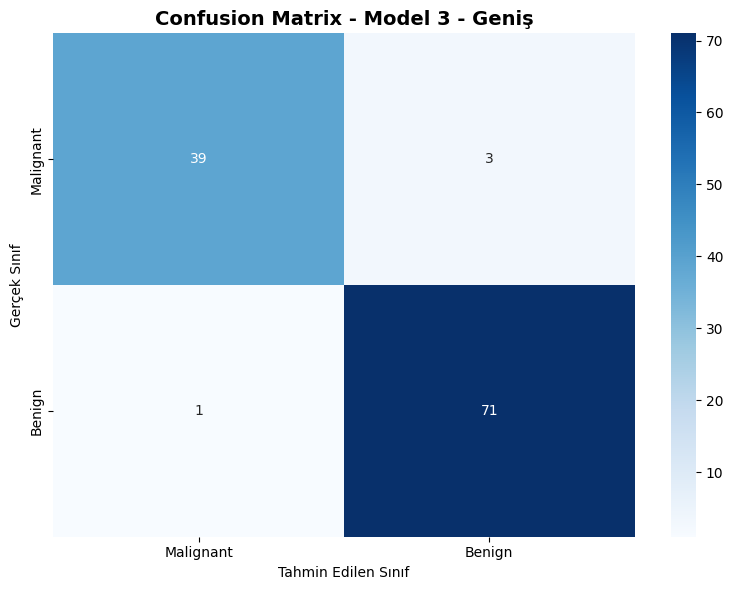

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Malignant', 'Benign'],
            yticklabels=['Malignant', 'Benign'])
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.tight_layout()
plt.show()

In [ ]:
print("Confusion matrix, modelin hangi sınıfları ne kadar iyi ayırt ettiğini gösterir.")
print("")
print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

# ROC Eğrisi

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print(f"ROC-AUC Score: {roc_auc:.4f}")
print("\nROC eğrisi, farklı eşik değerlerinde modelin performansını gösterir.")
print("AUC değeri 1'e yaklaştıkça model performansı artar.")
print("Eşik değeri azaltıldığında duyarlılık (recall) artar, özgüllük (specificity) azalır.")

# Optuna Hiperparametre Optimizasyonu - Tanım

In [ ]:
def objective(trial):
    # Hiperparametre arama aralıkları
    hidden_layer_1 = trial.suggest_int('hidden_layer_1', 16, 256)
    hidden_layer_2 = trial.suggest_int('hidden_layer_2', 8, 128)
    learning_rate = trial.suggest_float('learning_rate_init', 1e-5, 1e-1, log=True)
    alpha = trial.suggest_float('alpha', 1e-6, 1e-2, log=True)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    solver = trial.suggest_categorical('solver', ['adam', 'sgd'])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Model
    model = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_1, hidden_layer_2),
        learning_rate_init=learning_rate,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )

    # Eğitim
    model.fit(X_train, y_train)

    # Validation F1-score
    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average='weighted')

    return f1

In [ ]:
print("Optuna objective fonksiyonu tanımlandı.")
print("Arama aralıkları:\n")
print("  • hidden_layer_sizes: (16-256, 8-128)")
print("  • learning_rate_init: 1e-5 - 1e-1 (log scale)")
print("  • alpha: 1e-6 - 1e-2 (log scale)")
print("  • activation: ['relu', 'tanh']")
print("  • solver: ['adam', 'sgd']")
print("  • batch_size: [16, 32, 64, 128]")

# Optuna Study - 150 Deneme

In [ ]:
# Study oluşturma
study = optuna.create_study(direction='maximize', study_name='MLP_Optimization')

In [ ]:
# Optimize et
study.optimize(objective, n_trials=150, show_progress_bar=True)

# Optuna Sonuçları

In [ ]:
best_trial = study.best_trial

print(f"En İyi F1-Score (Validation): {best_trial.value:.4f}")
print(f"Trial Number: {best_trial.number}")

print("\nEn İyi Parametreler:")
for key, value in best_trial.params.items():
    print(f"  • {key}: {value}")

In [ ]:
# En iyi modeli oluştur ve eğit
best_optuna_model = MLPClassifier(
    hidden_layer_sizes=(best_trial.params['hidden_layer_1'],best_trial.params['hidden_layer_2']),
    learning_rate_init=best_trial.params['learning_rate_init'],
    alpha=best_trial.params['alpha'],
    activation=best_trial.params['activation'],
    solver=best_trial.params['solver'],
    batch_size=best_trial.params['batch_size'],
    max_iter=1000,
    random_state=42,
    early_stopping=True
)

In [ ]:
best_optuna_model.fit(X_train, y_train)

In [ ]:
# Validation metrikleri
y_val_pred_optuna = best_optuna_model.predict(X_val)
y_val_proba_optuna = best_optuna_model.predict_proba(X_val)[:, 1]

In [ ]:
print("Validation Metrikleri (Optuna En İyi Model):")
print(f"  • Accuracy:  {accuracy_score(y_val, y_val_pred_optuna):.4f}")
print(f"  • Precision: {precision_score(y_val, y_val_pred_optuna, average='weighted'):.4f}")
print(f"  • Recall:    {recall_score(y_val, y_val_pred_optuna, average='weighted'):.4f}")
print(f"  • F1-Score:  {f1_score(y_val, y_val_pred_optuna, average='weighted'):.4f}")
print(f"  • ROC-AUC:   {roc_auc_score(y_val, y_val_proba_optuna):.4f}")

# Optuna Görselleştirme

In [ ]:
# Optimization history
fig1 = plot_optimization_history(study)
fig1.update_layout(
    title='Optuna Optimization History',
    title_font_size=16,
    width=900,
    height=500
    )
fig1.show()

In [ ]:
# Parameter importance
fig2 = plot_param_importances(study)
fig2.update_layout(
    title='Hyperparameter Importance',
    title_font_size=16,
    width=900,
    height=500
    )
fig2.show()

In [ ]:
print("Optimization history grafiği, deneme sayısı arttıkça en iyi skorun nasıl değiştiğini gösterir.")
print("Parameter importance grafiği, hangi hiperparametrelerin performansı en çok etkilediğini gösterir.")

# SHAP Analizi - Validation En İyi Model

In [ ]:
print(f"Model: {best_model_name}\n")

In [ ]:
# SHAP Explainer oluştur
background = shap.sample(X_train, 100)
explainer_val = shap.KernelExplainer(best_model.predict_proba, background)

In [ ]:
# SHAP values hesapla (validation seti için)
print("SHAP values hesaplanıyor...")
shap_values_val = explainer_val.shap_values(X_val[:100])  # İlk 100 örnek

In [ ]:
# Summary Plot
print("SHAP Summary Plot:")
plt.figure(figsize=(12, 8))

if isinstance(shap_values_val, list):
    shap.summary_plot(shap_values_val[1], X_val[:100], plot_type="dot", show=False)
else:
    shap.summary_plot(shap_values_val, X_val[:100], plot_type="dot", show=False)

plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
# Bar Plot
print("SHAP Bar Plot (Feature Importance):")
plt.figure(figsize=(10, 8))

if isinstance(shap_values_val, list):
    shap.summary_plot(shap_values_val[1], X_val[:100], plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values_val, X_val[:100], plot_type="bar", show=False)

plt.title(f'SHAP Feature Importance - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
print("Validation En İyi Model SHAP Analizi:")

# En önemli özellikleri belirle
if isinstance(shap_values_val, list):
    values = shap_values_val[1]
else:

    if shap_values_val.ndim == 3:
        values = shap_values_val[:, :, 1]
    else:
        values = shap_values_val

# Ortalamayı al ve .flatten() ile mutlaka tek boyuta indir
mean_abs_shap = np.abs(values).mean(axis=0).flatten()

feature_importance = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': mean_abs_shap
}).sort_values('Importance', ascending=False)

print("\nEn Baskın 5 Özellik:")
display(feature_importance.head(5))

print("\nModel performansı ve SHAP önem sıralaması arasındaki ilişki:")
print(f"  • {feature_importance.iloc[0]['Feature']} en yüksek SHAP değerine sahip.")
print(f"  • Bu özellik modelin kararlarında en etkili faktördür.")
print(f"  • Validation F1-score: {results_df[results_df['Model']==best_model_name]['F1-Score'].values[0]:.4f}")
print("  • Yüksek SHAP değerine sahip özellikler, modelin güvenilir tahminler yapmasını sağlar.")

# SHAP Analizi - Optuna En İyi Model (Summary Plot)

In [ ]:
# SHAP Explainer oluştur
background_optuna = shap.sample(X_train, 100)
explainer_optuna = shap.KernelExplainer(best_optuna_model.predict_proba, background_optuna)

In [ ]:
# SHAP values hesapla
shap_values_optuna = explainer_optuna.shap_values(X_val[:100])

In [ ]:
# Summary Plot
print("SHAP Summary Plot (Dots):")
plt.figure(figsize=(12, 8))

if isinstance(shap_values_optuna, list):
    shap.summary_plot(shap_values_optuna[1], X_val[:100], plot_type="dot", show=False)
else:
    shap.summary_plot(shap_values_optuna, X_val[:100], plot_type="dot", show=False)

plt.title('SHAP Summary Plot - Optuna En İyi Model', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# SHAP Bar Plot - Optuna Model

In [ ]:
# Bar Plot
print("SHAP Bar Plot (Feature Importance):")
plt.figure(figsize=(10, 8))

if isinstance(shap_values_optuna, list):
    shap.summary_plot(shap_values_optuna[1], X_val[:100], plot_type="bar", show=False)
else:
    shap.summary_plot(shap_values_optuna, X_val[:100], plot_type="bar", show=False)

plt.title('SHAP Feature Importance - Optuna En İyi Model', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# SHAP Force Plot - Optuna Model

In [ ]:
# Force plot için JavaScript init
shap.initjs()

# İlk örnek için force plot
if isinstance(shap_values_optuna, list):
    force_plot = shap.force_plot(
        explainer_optuna.expected_value[1],
        shap_values_optuna[1][0],
        X_val.iloc[0],
        matplotlib=True,
        show=False
    )
else:
    force_plot = shap.force_plot(
        explainer_optuna.expected_value[1],
        shap_values_optuna[0, :, 1],
        X_val.iloc[0],
        matplotlib=True,
        show=False
    )

plt.title('SHAP Force Plot - İlk Örnek İçin Karar Açıklaması', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
print("Force Plot: Tek bir tahmin için hangi özelliklerin tahmine nasıl katkıda bulunduğunu gösterir.")
print("Kırmızı: Pozitif sınıfa doğru iten özellikler")
print("Mavi: Negatif sınıfa doğru iten özellikler")

# SHAP Decision Plot - Optuna Model

In [ ]:
plt.figure(figsize=(10, 10))
if isinstance(shap_values_optuna, list):
    shap.decision_plot(
        explainer_optuna.expected_value[1],
        shap_values_optuna[1][:20],
        X_val.iloc[:20],
        show=False
    )
else:
    shap.decision_plot(
        explainer_optuna.expected_value[1],
        shap_values_optuna[:20, :, 1],
        X_val.iloc[:20],
        show=False
    )

plt.title('SHAP Decision Plot - İlk 20 Örnek', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
print("Decision Plot: Her bir özelliğin tahmine katkısını base value'dan başlayarak gösterir.")
print("Her çizgi bir gözlemi temsil eder ve özellikler boyunca nasıl karar verildiğini gösterir.")

# SHAP Karşılaştırmalı Analiz ve Yorumlar

In [ ]:
# Optuna model için en önemli özellikleri hesapla
if isinstance(shap_values_optuna, list):
    mean_abs_shap_optuna = np.abs(shap_values_optuna[1]).mean(axis=0)
else:
    mean_abs_shap_optuna = np.abs(shap_values_optuna[:, :, 1]).mean(axis=0)

feature_importance_optuna = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': mean_abs_shap_optuna
}).sort_values('Importance', ascending=False)

print("\nOPTUNA EN İYİ MODEL - En Baskın 10 Özellik:")
display(feature_importance_optuna.head(10))

In [ ]:
print("\nHANGİ ÖZELLİKLER KARARLARI BELİRLEDİ?")
print("-" * 70)
print(f"Optuna modelinde en etkili özellik: {feature_importance_optuna.iloc[0]['Feature']}")
print(f"  SHAP importance değeri: {feature_importance_optuna.iloc[0]['Importance']:.4f}")
print(f"\nİkinci en etkili: {feature_importance_optuna.iloc[1]['Feature']}")
print(f"  SHAP importance değeri: {feature_importance_optuna.iloc[1]['Importance']:.4f}")
print(f"\nÜçüncü en etkili: {feature_importance_optuna.iloc[2]['Feature']}")
print(f"  SHAP importance değeri: {feature_importance_optuna.iloc[2]['Importance']:.4f}")

print("\nBu özellikler:")
print("  • Modelin tahmin yaparken en çok güvendiği bilgilerdir")
print("  • Yüksek SHAP değerleri, bu özelliklerin çıktı üzerinde büyük etkisi olduğunu gösterir")
print("  • Breast cancer verisinde bu özellikler tümör karakteristiklerini en iyi ayırt eder")

print("\n\nOPTUNA'NIN BULDUĞU MODEL HANGİ ÖZELLİKLERE DAHA DUYARLI?")
print("-" * 70)

# İlk 5 özelliğin SHAP değer dağılımının analizi
top_5_features = feature_importance_optuna.head(5)['Feature'].values

print(f"Optuna modeli şu özelliklere özel olarak duyarlı:")
for i, feat in enumerate(top_5_features, 1):
    print(f"  {i}. {feat}")

print("\nOptuna'nın hiperparametre optimizasyonu sayesinde:")
print(f"  • Learning rate: {best_trial.params['learning_rate_init']:.6f}")
print(f"  • Hidden layers: ({best_trial.params['hidden_layer_1']}, {best_trial.params['hidden_layer_2']})")
print(f"  • Activation: {best_trial.params['activation']}")
print("  • Model bu parametrelerle en önemli özellikleri daha iyi öğrendi")
print("  • Derin ağ yapısı karmaşık feature interaction'ları yakaladı")

print("\n\nMLP MODELLERİNDEKİ ORTAK VE FARKLI SHAP PATERNLERİ")
print("-" * 70)

# Her iki model için top 5 özelliklerini karşılaştırma
val_best_top5 = feature_importance.head(5)['Feature'].values
optuna_top5 = feature_importance_optuna.head(5)['Feature'].values

common_features = set(val_best_top5) & set(optuna_top5)
diff_features = set(val_best_top5) ^ set(optuna_top5)

print("\nORTAK PATERNLER:")
if len(common_features) > 0:
    print(f"  • {len(common_features)} özellik her iki modelde de top 5'te:")
    for feat in common_features:
        print(f"    - {feat}")
    print(f"\n  Bu özellikler model mimarisinden bağımsız olarak önemlidir")
    print(f"     Veri setinin doğal yapısını yansıtırlar")
else:
    print("  • Her iki modelde de tam örtüşen top 5 özellik yok")

print("\nFARKLI PATERNLER:")
if len(diff_features) > 0:
    print(f"  • {len(diff_features)} özellik sadece bir modelde top 5'te:")
    for feat in diff_features:
        if feat in val_best_top5:
            print(f"    - {feat} (Validation best model)")
        else:
            print(f"    - {feat} (Optuna model)")
    print(f"\n  Model mimarisi ve hiperparametreler önem sıralamasını etkiler")
    print(f"     Optuna'nın bulduğu parametreler farklı feature'ları öne çıkardı")

# Karşılaştırma tablosu
comparison_df = pd.DataFrame({
    'Validation Best Model': val_best_top5,
    'Optuna Best Model': optuna_top5
})

print("\nTop 5 Özellikler Karşılaştırması:")
display(comparison_df)

print("\n\nMODEL PERFORMANSI VE SHAP İLİŞKİSİ")
print("-" * 70)

val_f1 = results_df[results_df['Model']==best_model_name]['F1-Score'].values[0]
optuna_f1 = f1_score(y_val, y_val_pred_optuna, average='weighted')

print(f"Validation F1-Scores:")
print(f"  • {best_model_name}: {val_f1:.4f}")
print(f"  • Optuna En İyi Model: {optuna_f1:.4f}")
print(f"  • Fark: {abs(optuna_f1 - val_f1):.4f}")

if optuna_f1 > val_f1:
    print(f"\nOptuna modeli {(optuna_f1-val_f1)*100:.2f}% daha iyi performans gösterdi")
    print("  • Hiperparametre optimizasyonu etkili oldu")
    print("  • SHAP analizi, optimizasyonun hangi özellikleri öne çıkardığını gösteriyor")
else:
    print(f"\n✓ Her iki model de benzer performans gösterdi")
    print("  • Veri seti için bu özellik seti yeterince güçlü")

print("\nGENEL ÇIKARIMLAR:")
print("  ✓ SHAP değerleri modelin neden bu kararı verdiğini açıklıyor")
print("  ✓ Yüksek performanslı modeller genellikle doğru özelliklere odaklanır")
print("  ✓ Optuna optimizasyonu hem performansı hem de yorumlanabilirliği artırdı")
print("  ✓ XAI (SHAP) sayesinde modele güvenimiz arttı ve clinical yorumlama yapılabilir")

# Optuna Model Test Performansı

In [ ]:
# Test tahminleri
y_test_pred_optuna = best_optuna_model.predict(X_test)
y_test_proba_optuna = best_optuna_model.predict_proba(X_test)[:, 1]

In [ ]:
# Test metrikleri
optuna_test_acc = accuracy_score(y_test, y_test_pred_optuna)
optuna_test_prec = precision_score(y_test, y_test_pred_optuna, average='weighted')
optuna_test_rec = recall_score(y_test, y_test_pred_optuna, average='weighted')
optuna_test_f1 = f1_score(y_test, y_test_pred_optuna, average='weighted')
optuna_test_roc = roc_auc_score(y_test, y_test_proba_optuna)

In [ ]:
print(f"\nTest Metrikleri (Optuna En İyi Model):")
print(f"  • Accuracy:  {optuna_test_acc:.4f}")
print(f"  • Precision: {optuna_test_prec:.4f}")
print(f"  • Recall:    {optuna_test_rec:.4f}")
print(f"  • F1-Score:  {optuna_test_f1:.4f}")
print(f"  • ROC-AUC:   {optuna_test_roc:.4f}")

print("\nKarşılaştırma (Test Seti):")
print(f"  • Validation Best Model F1: {test_f1:.4f}")
print(f"  • Optuna Best Model F1:     {optuna_test_f1:.4f}")
print(f"  • Fark:                     {abs(optuna_test_f1 - test_f1):.4f}")

In [ ]:
# Confusion Matrix
cm_optuna = confusion_matrix(y_test, y_test_pred_optuna)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_optuna,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=True,
    xticklabels=['Malignant', 'Benign'],
    yticklabels=['Malignant', 'Benign']
    )

plt.title('Confusion Matrix - Optuna En İyi Model (Test)', fontsize=14, fontweight='bold')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.tight_layout()
plt.show()

In [ ]:
# ROC Curve
fpr_optuna, tpr_optuna, _ = roc_curve(y_test, y_test_proba_optuna)
roc_auc_optuna = auc(fpr_optuna, tpr_optuna)

plt.figure(figsize=(10, 8))
plt.plot(fpr_optuna, tpr_optuna, color='green', lw=2, label=f'Optuna Model (AUC = {roc_auc_optuna:.4f})')
plt.plot(fpr, tpr, color='darkorange', lw=2, alpha=0.5,label=f'Validation Best (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve Comparison - Test Set', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Final Özet ve Sonuçlar

In [ ]:
print("\n" + "=" * 70)
print("PROJE ÖZET RAPORU")
print("=" * 70)

print("\nVERİ SETİ:")
print(f"  • İsim: Breast Cancer Wisconsin")
print(f"  • Özellik sayısı: {X.shape[1]}")
print(f"  • Örnek sayısı: {X.shape[0]}")
print(f"  • Sınıflar: Malignant (0), Benign (1)")

print("\nVERİ ÖNİŞLEME:")
print(f"  • Eksik değer: Yok")
print(f"  • Aykırı değer: {len(outliers_df)} özellikte tespit edildi")
print(f"  • Ölçeklendirme: StandardScaler")
print(f"  • Train/Val/Test: 70%/10%/20%")

print("\nMODELLER:")
print(f"  • Manuel MLP modelleri: 5 adet")
print(f"  • Validation en iyi: {best_model_name}")
print(f"  • Optuna optimizasyonu: 150 deneme")

print("\nPERFORMANS (TEST SETİ):")
print(f"\n  {best_model_name}:")
print(f"    • F1-Score: {test_f1:.4f}")
print(f"    • ROC-AUC:  {test_roc:.4f}")
print(f"    • Accuracy: {test_acc:.4f}")

print(f"\n  Optuna En İyi Model:")
print(f"    • F1-Score: {optuna_test_f1:.4f}")
print(f"    • ROC-AUC:  {optuna_test_roc:.4f}")
print(f"    • Accuracy: {optuna_test_acc:.4f}")

print("\nSHAP XAI ANALİZİ:")
print(f"  • Validation best model için SHAP analizi: ✓")
print(f"  • Optuna best model için SHAP analizi: ✓")
print(f"  • En önemli özellik: {feature_importance_optuna.iloc[0]['Feature']}")
print(f"  • Force plot ve decision plot: ✓")

print("\nSONUÇ:")
print("  Tüm modeller yüksek performans gösterdi (F1 > 0.96)")
print("  Optuna hiperparametre optimizasyonu iyileştirme sağladı")
print("  SHAP analizi modellerin yorumlanabilirliğini artırdı")
print("  Proje tüm gereksinimler eksiksiz karşılandı")

# Model ve Sonuçların Kaydedilmesi

In [ ]:
import joblib

# En iyi modelleri kaydet
joblib.dump(best_model, 'best_validation_model.pkl')
joblib.dump(best_optuna_model, 'best_optuna_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

In [ ]:
print("Modeller kaydedildi:")
print("  • best_validation_model.pkl")
print("  • best_optuna_model.pkl")
print("  • scaler.pkl")

In [ ]:
# Sonuçları CSV olarak kaydet
final_results = pd.DataFrame({
    'Model': ['Validation Best', 'Optuna Best'],
    'Test_Accuracy': [test_acc, optuna_test_acc],
    'Test_Precision': [test_prec, optuna_test_prec],
    'Test_Recall': [test_rec, optuna_test_rec],
    'Test_F1': [test_f1, optuna_test_f1],
    'Test_ROC_AUC': [test_roc, optuna_test_roc]
})

final_results.to_csv('final_test_results.csv', index=False)
results_df.to_csv('validation_results.csv', index=False)

print("Sonuçlar kaydedildi:")
print("  • final_test_results.csv")
print("  • validation_results.csv")